In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#创建一个reader来读取TFRecord文件中的样例
reader = tf.TFRecordReader()
# filename = tf.train.string_input_producer(['car_train.tfrecords'])
filename = tf.train.string_input_producer(['car_tset.tfrecords'])
#从文件中读取一个样例
_, one_example = reader.read(filename)
#解析读入的数据
features = tf.parse_single_example(one_example,features={
    'labels':tf.FixedLenFeature([], tf.int64),
    'image_raw':tf.FixedLenFeature([], tf.string),
    'img_width':tf.FixedLenFeature([], tf.int64),
    'img_high':tf.FixedLenFeature([], tf.int64)
})
#将字符串解析成图像对应的像素数组
images = tf.decode_raw(features['image_raw'], tf.uint8)
images = tf.reshape(images, [48, 24, 1])
print(images)
labels = tf.cast(features['labels'], tf.int32)
widths = tf.cast(features['img_width'], tf.int32)
highs = tf.cast(features['img_high'], tf.int32)

images_bath, labels_bath = tf.train.shuffle_batch([images, labels], batch_size = 100, capacity = 4000, 
                                                  min_after_dequeue = 3888, 
                                                  num_threads = 2,
                                                  shapes = ([48,24,1],[]))
print(labels_bath.shape[0])
print(labels_bath[2])
# with tf.Session() as sess:
#     #启动多线程
#     sess.run(init)
#     sess.run(tf.local_variables_initializer())
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(sess=sess, coord = coord)
#     for i in range(1,10):
#         image, label = sess.run([images_bath, labels_bath])
#         print(image.shape)
# #         print(highs, widths)
#         for i in range(1,100):
#             plt.imshow(image[i].reshape(48, 24), cmap = 'gray')
#             plt.show()
#     coord.request_stop()
#     coord.join(threads)

Tensor("Reshape:0", shape=(48, 24, 1), dtype=uint8)
100
Tensor("strided_slice:0", shape=(), dtype=int32)


In [3]:
acc_num = 0
acc_fin = 0
learning_rate = 0.001


def hot(x):
    a = np.zeros([x.shape[0],34])
    for i in range(x.shape[0]):
        a[i][x[i]-1] = 1
    return a


# Input layer
X = tf.placeholder(tf.float32, [None, 48, 24, 1])
Y = tf.placeholder(tf.float32, [None, 34])
# Layer 1
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 90], stddev = 0.1))
b1 = tf.Variable(tf.constant(0.0, shape=[90]))
conv1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'VALID')
tanh1 = tf.nn.tanh(tf.nn.bias_add(conv1,b1))
# Layer 2
pool1=tf.nn.max_pool(tanh1,ksize=[1,2,2,1],strides=[1,2,2,1],padding = "SAME")
# layer 3
W2 = tf.Variable(tf.truncated_normal([5, 5, 90, 60], stddev = 0.1))
b2 = tf.Variable(tf.constant(0.0, shape=[60]))
conv2 = tf.nn.conv2d(pool1, W2, strides = [1,1,1,1], padding = "VALID")
tanh2 = tf.nn.tanh(tf.nn.bias_add(conv2,b2))
# layer 4
pool2=tf.nn.max_pool(tanh2,ksize=[1,3,3,1],strides=[1,3,3,1],padding = "SAME")
pool_size = tf.shape(pool2)
reshape = tf.reshape(pool2,[pool_size[0],-1])
# layer 5
fc1_weight = tf.Variable(tf.truncated_normal([720,300],stddev = 0.1))
fc1_bias=tf.Variable(tf.constant(0.0,shape=[300]))
fc1 = tf.nn.tanh(tf.matmul(reshape,fc1_weight)+fc1_bias)
# layer 6
fc2_weight = tf.Variable(tf.truncated_normal([300,34], stddev = 0.1))
fc2_bias=tf.Variable(tf.constant(0.0, shape=[34]))
fc2 = tf.nn.softmax(tf.matmul(fc1, fc2_weight)+fc2_bias)
#cross function
cross_entropy = - tf.reduce_sum(Y * tf.log(fc2))
is_correct = tf.equal(tf.argmax(fc2, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print(tf.argmax(fc2, 1)[0])
print(tf.argmax(Y,1)[0])
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

# saver
cnn_txt = "./cnn_txt"
if not os.path.exists(cnn_txt):
    os.makedirs(cnn_txt)

saver = tf.train.Saver()
with tf.Session() as sess:
    #启动多线程
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord = coord)
    txt = tf.train.get_checkpoint_state(cnn_txt)
    if txt and txt.model_checkpoint_path:
        print(txt.model_checkpoint_path)
        saver.restore(sess, txt.model_checkpoint_path)
    L_true = np.zeros([34])
    L_num = np.zeros([34])
    L_recall = []
    for epoch in range(100):
        # Load the input data
        image, label = sess.run([images_bath, labels_bath])
        train_data = {X: image, Y: hot(label)}
        
        yy = sess.run([fc2], feed_dict = train_data)
        y = yy[0]
        for i in range(100):
#             print(label[i])
#             print(np.argmax(y[i]))
#             print("ok")
            if label[i]-1 == np.argmax(y[i]):
                L_true[label[i]] += 1
            L_num[label[i]] += 1
        # Train
        sess.run(train_step, feed_dict = train_data)
        
        # Accuracy on training data
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict = train_data)
        acc_num = acc*100 + acc_num
#         # Trying it out on test data
#         test_data = {X: mnist_data.test.images, Y_: mnist_data.test.labels}

#         # Accuracy on test data
#         acc_test, loss_test = sess.run([accuracy, cross_entropy], feed_dict = test_data)
#         saver.save(sess,cnn_txt + "/model.ckpt")
        if epoch % 10 ==0:
            print("epoch: %d ,accuracy is: %g ,loss is : %g" % (epoch, acc, loss))
    acc_fin = acc_num/10000
    print("acc_finally: %g" % acc_fin)
#     print(L_num)
#     print(L_true)
    for i in range(34):
#         print(L_true[i] / L_num[i])
        L_recall.append(L_true[i]/L_num[i])
    L_recall[0] = 1
#     print(L_recall)
    coord.request_stop()
    coord.join(threads)
    

Tensor("strided_slice_2:0", shape=(), dtype=int64)
Tensor("strided_slice_3:0", shape=(), dtype=int64)
./cnn_txt/model.ckpt
INFO:tensorflow:Restoring parameters from ./cnn_txt/model.ckpt
epoch: 0 ,accuracy is: 0.9 ,loss is : 67.72
epoch: 10 ,accuracy is: 0.91 ,loss is : 46.3906
epoch: 20 ,accuracy is: 0.93 ,loss is : 36.7439
epoch: 30 ,accuracy is: 0.97 ,loss is : 18.3213
epoch: 40 ,accuracy is: 0.97 ,loss is : 14.6652
epoch: 50 ,accuracy is: 0.95 ,loss is : 25.0977
epoch: 60 ,accuracy is: 0.95 ,loss is : 18.5154
epoch: 70 ,accuracy is: 0.91 ,loss is : 35.8331
epoch: 80 ,accuracy is: 0.95 ,loss is : 32.3328
epoch: 90 ,accuracy is: 0.96 ,loss is : 18.2108
acc_finally: 0.9366


('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')


/home/yanzhao/six/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


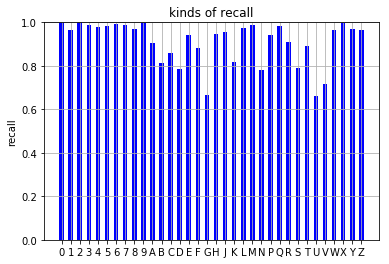

In [9]:
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B', 12:'C', 13:'D',14:'E',15:'F', 16:'G', 17:'H', 18:'J', 19:'K', 20:'L', 21:'M', 22:'N', 23:'P', 24:'Q', 25:'R', 26:'S', 27:'T', 28:'U', 29:'V', 30:'W', 31:'X', 32:'Y', 33:'Z'} 
classes = labels.values()
k = tuple(classes)
print(k)
fig=plt.figure(1)
ax1=plt.subplot(111)
data=np.array(L_recall)
width=0.5
x_bar=np.arange(34)
rect=ax1.bar(left=x_bar,height=data,width=width,color="blue")
ax1.set_xticks(x_bar)
ax1.set_xticklabels(k)
ax1.set_ylabel("recall")
ax1.set_title("kinds of recall")
ax1.grid(True)
ax1.set_ylim(0,1)
plt.show()